In [0]:
"""this file contains the code to generate loss curves,
reconstruction comparisons, and latent traversals 
for roud 2 training (additional 200 epochs)"""
import sys
print(sys.version)
%matplotlib inline
%tensorflow_version 2.x

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import typing
import math
import tqdm
import os
import itertools
import uuid
import copy
import subprocess
import imageio
import IPython


from IPython import display
from IPython.display import Image
from pathlib import Path
from enum import IntEnum
print(tf.__version__)

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
TensorFlow 2.x selected.
2.2.0-rc1


In [0]:
from dsprites import imshow, make_grid
import run_dsprites_models as dsvae

In [0]:
#np.load.__defaults__=(None, True, True, 'ASCII')

In [0]:
ds = dsvae.download_data()
LATENT_DIM=10

In [0]:
def display_model_random(model, x):
    '''displays a random set of original and reconstructed imgs
    :param model: a vae model to reconstruct from
    :param x: a numpy array representing the images
    '''
    z, *_= model.encode(x) # should return z (latents) and mean/logvar
    x_recon = tf.nn.sigmoid(model.decode(z)).numpy() # generate reconstructed images
    fig = plt.figure(figsize=(20, 20)) 
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    imshow(make_grid(x), title='Original', ax=ax1)
    imshow(make_grid(x_recon), title='Reconstructed', ax=ax2)
    fig.subplots_adjust(wspace=0.01)
    plt.show()
    
def plot_losses(losses):
    '''given an array of losses, plots'''
    plt.plot(losses)
    plt.title("Average epoch loss")
    plt.xlabel("Epoch")
    plt.ylabel("ELBO loss")
    plt.show()
    
def grab_img(set, num):
    '''grabs numth (0index) image from set'''
    return np.array([set[num]])


def step_latents(img, model, size=1, num_var=5):
    """varies each latent up and down by step size
    :param img: nparray of img (1,64,64,1)
    :param model: the model to encode with
    :param size:=1 the step size to vary latents
    :param num_var:=5 int) number of steps up (will automatically 
    do same num steps down)
    
    TODO: take a vector in order to vary the steps non uniformly
    
    :return tensor object of latent encodings for all step variations 
    of each latent (tf.Tensor([[...]...],shape=((num_var*2+1)*LATENT_DIM,LATENT_DIM),
     dtype=float32)
    """
    #x = ds.subset(size=1)
    z, *_ = model.encode(img)
    #print(z)
    z0 = tf.identity(z)
    #print(z0)
    array = [[0,0,0,0,0,0,0,0,0,0]]
    for apos in range(LATENT_DIM):
        array[0][apos] = 1
        zr = tf.identity(z0)
        for step in range(1,num_var+1,size):
            temp1 = [i*step for i in array[0]]
            tempn1 = [i*((-1)*step) for i in array[0]]
            #print([temp1])
            #print([tempn1])
            t1 = tf.add(z0,[temp1])
            tn1 = tf.add(z0,[tempn1])
            zr = tf.concat([tn1,zr,t1],0)
        array[0][apos] = 0
        if apos == 0:
            z = tf.identity(zr)
        else:
            z = tf.concat([z,zr],0)
    return z

def qual_latent_analysis(img, model, size=1, num_var=5, text=""):
    """varies each latent up and down by step size
    :param img: nparray of img (1,64,64,1)
    :param model: the model to encode with
    :param size:=1 the step size to vary latents
    :param num_var:=5 int) number of steps up (will automatically 
    do same num steps down)
    
    TODO: take a vector in order to vary the steps non uniformly
    
    :return displays graphic for visual analysis
    """
    z = step_latents(img, model, size, num_var)
    #print(z.shape)
    z_dis_recon = tf.nn.sigmoid(model.decode(z)).numpy()
    print(text)
    imshow(make_grid(z_dis_recon, nrow=num_var*2+1, pad_value=1))

In [0]:
'''v = ["vae0.5_weights_100e_550ktr.h5","vae1_weights_100-300e_550ktr_sup.h5",
    "vae2_weights_100e_550ktr.h5", "vae3_weights_100-300e_550ktr_sup.h5",
    "vae4_weights_100-300e_550ktr_sup.h5", "vae5_weights_100-300e_550ktr_sup.h5",
    "vae6_weights_100e_550ktr.h5", "vae7_weights_100-300e_550ktr_sup.h5",
    "vae8_weights_100e_550ktr.h5", "vae9_weights_100e_550ktr.h5",
     "vae10_weights_100e_550ktr.h5"]
vl = ["vae0.5_losses_100e_550ktr.txt","vae1_losses_100-300e_550ktr_sup.txt",
    "vae2_losses_100e_550ktr.txt", "vae3_losses_100-300e_550ktr_sup.txt",
    "vae4_losses_100-300e_550ktr_sup.txt", "vae5_losses_100-300e_550ktr_sup.txt",
    "vae6_losses_100e_550ktr.txt", "vae7_losses_100-300e_550ktr_sup.txt",
    "vae8_losses_100e_550ktr.txt", "vae9_losses_100e_550ktr.txt",
    "vae10_losses_100e_550ktr.txt"]
'''
v = [0,"vae1_weights_100-300e_550ktr_sup.h5",
    2, "vae3_weights_100-300e_550ktr_sup.h5",
    "vae4_weights_100-300e_550ktr_sup.h5", "vae5_weights_100-300e_550ktr_sup.h5",
    6, "vae7_weights_100-300e_550ktr_sup.h5"]
vl1 = [0,"vae1_losses_100e_550ktr.txt",
    2, "vae3_losses_100e_550ktr.txt",
    "vae4_losses_100e_550ktr.txt", "vae5_losses_100e_550ktr.txt",
    6, "vae7_losses_100e_550ktr.txt"]
vl2 = [0,"vae1_losses_100-300e_550ktr_sup.txt",
    2, "vae3_losses_100-300e_550ktr_sup.txt",
    "vae4_losses_100-300e_550ktr_sup.txt", "vae5_losses_100-300e_550ktr_sup.txt",
    6, "vae7_losses_100-300e_550ktr_sup.txt"]
v0_5l = "vae0.5_losses_100e_550ktr.txt"


In [0]:
test = np.load('test_imgs.npy')

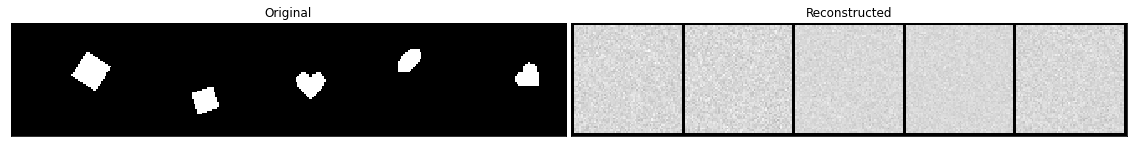

In [0]:
blankvae = dsvae.VAE(latent_dim=LATENT_DIM)
display_model_random(blankvae, test)

In [0]:
x_o = grab_img(test,3)
x_s = grab_img(test,1)
x_h = grab_img(test,2) 

In [0]:
def combinelosses(betaval):
  t1 = np.loadtxt(vl1[betaval])
  t2 = np.loadtxt(vl2[betaval])
  losses = np.concatenate((t1,t2), axis=0)
  return losses

def load_models():
  models = []
  for model in range(8):
    if type(v[model])== str:
      models.append(load_model(v[model]))
    else:
      models.append(v[model])
  return models

def load_model(weights):
  tmodel = dsvae.VAE(latent_dim=LATENT_DIM)
  tmodel.load_weights(weights)
  return tmodel
# used tf docs to learn how to save and load models
# https://www.tensorflow.org/tutorials/keras/save_and_load


vae1_losses_100e_550ktr.txt
vae1_losses_100-300e_550ktr_sup.txt
Loss Curve for VAE1


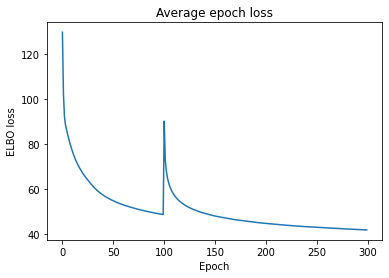

vae3_losses_100e_550ktr.txt
vae3_losses_100-300e_550ktr_sup.txt
Loss Curve for VAE3


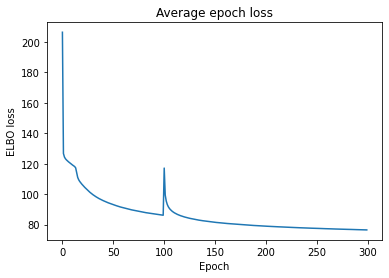

vae4_losses_100e_550ktr.txt
vae4_losses_100-300e_550ktr_sup.txt
Loss Curve for VAE4


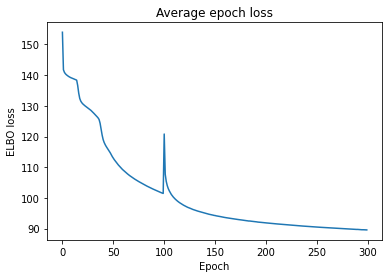

vae5_losses_100e_550ktr.txt
vae5_losses_100-300e_550ktr_sup.txt
Loss Curve for VAE5


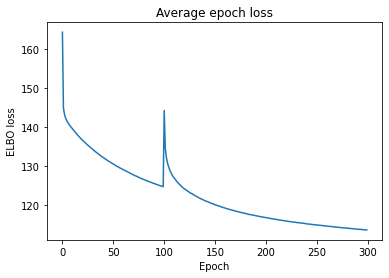

vae7_losses_100e_550ktr.txt
vae7_losses_100-300e_550ktr_sup.txt
Loss Curve for VAE7


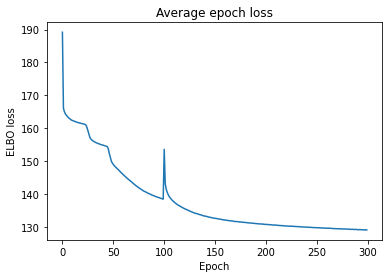

In [0]:
#display loss curves
for model in range(8):
  if type(vl1[model])== str:
    print(vl1[model])
    print(vl2[model])
    temploss = combinelosses(model)
    print("Loss Curve for VAE"+str(model))
    plot_losses(temploss)


In [0]:
#play with vae0 loss curves
l05 = np.loadtxt(v0_5l)

Loss Curve for VAE7


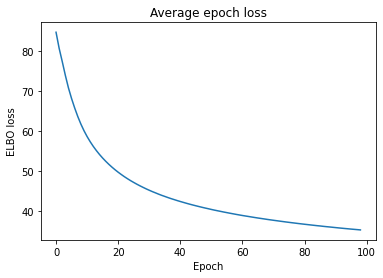

In [0]:
l05_2 = np.copy(l05[1:])
#l05_2[0] = 0
print("Loss Curve for VAE"+str(model))
plot_losses(l05_2)

In [0]:
# create reconstruction images
load_weights()

vae1_weights_100-300e_550ktr_sup.h5
vae3_weights_100-300e_550ktr_sup.h5
vae4_weights_100-300e_550ktr_sup.h5
vae5_weights_100-300e_550ktr_sup.h5
vae7_weights_100-300e_550ktr_sup.h5


In [0]:
models = load_models()

Reconstruction for VAE1
ERROR! Session/line number was not unique in database. History logging moved to new session 64


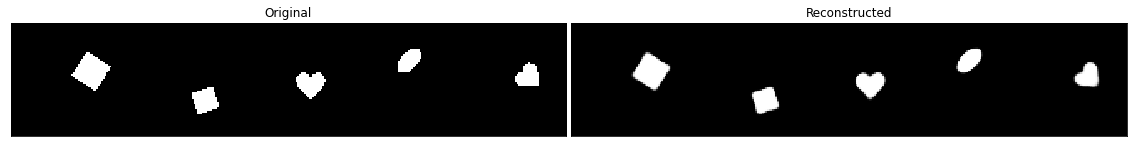

Reconstruction for VAE3


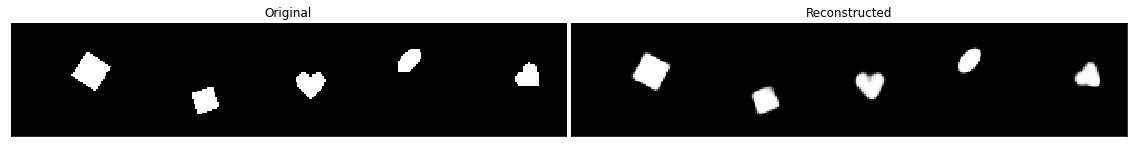

Reconstruction for VAE4


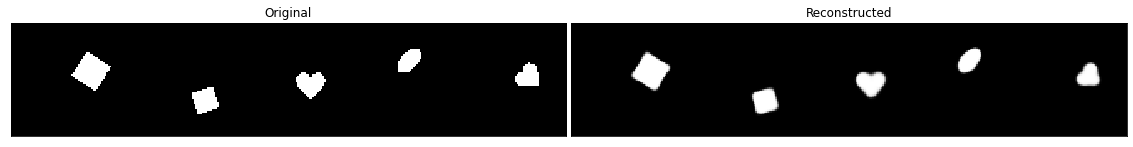

Reconstruction for VAE5


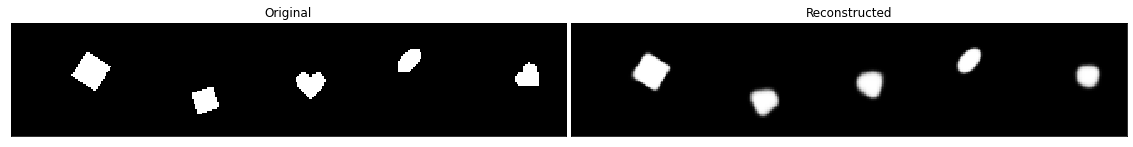

Reconstruction for VAE7


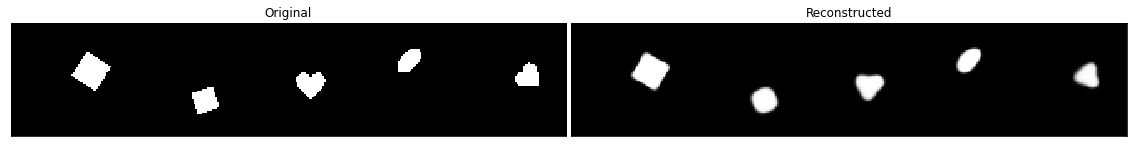

In [0]:
ctr = 0
for model in models:
  if type(model) != int:
    print("Reconstruction for VAE"+str(ctr))
    display_model_random(model,test)
  ctr +=1

Square Disentanglement Example for VAE1
Square Disentanglement Example for VAE3
Square Disentanglement Example for VAE4
Square Disentanglement Example for VAE5
Square Disentanglement Example for VAE7


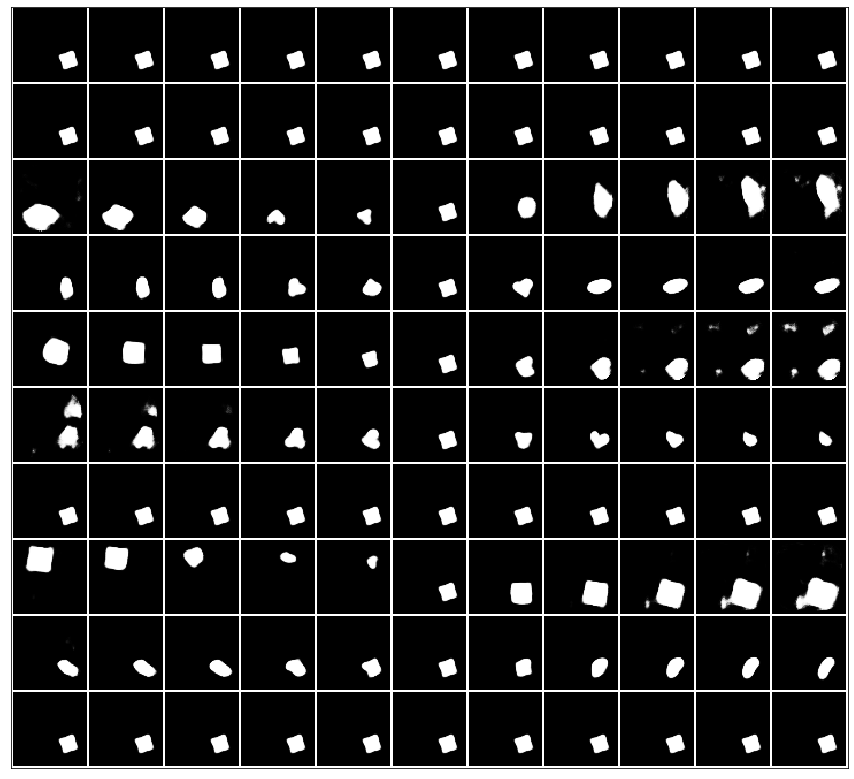

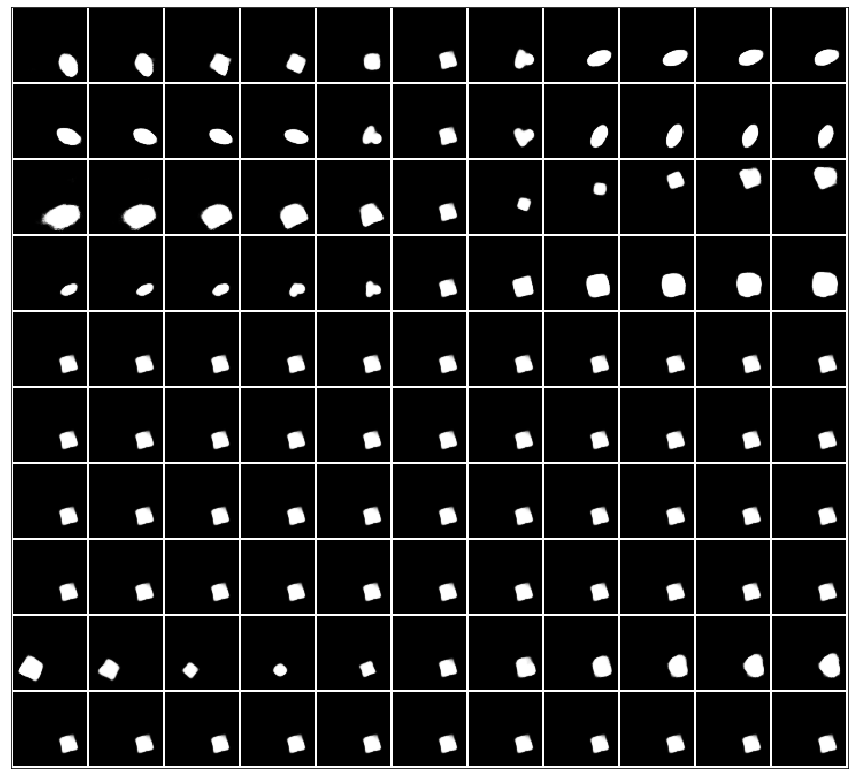

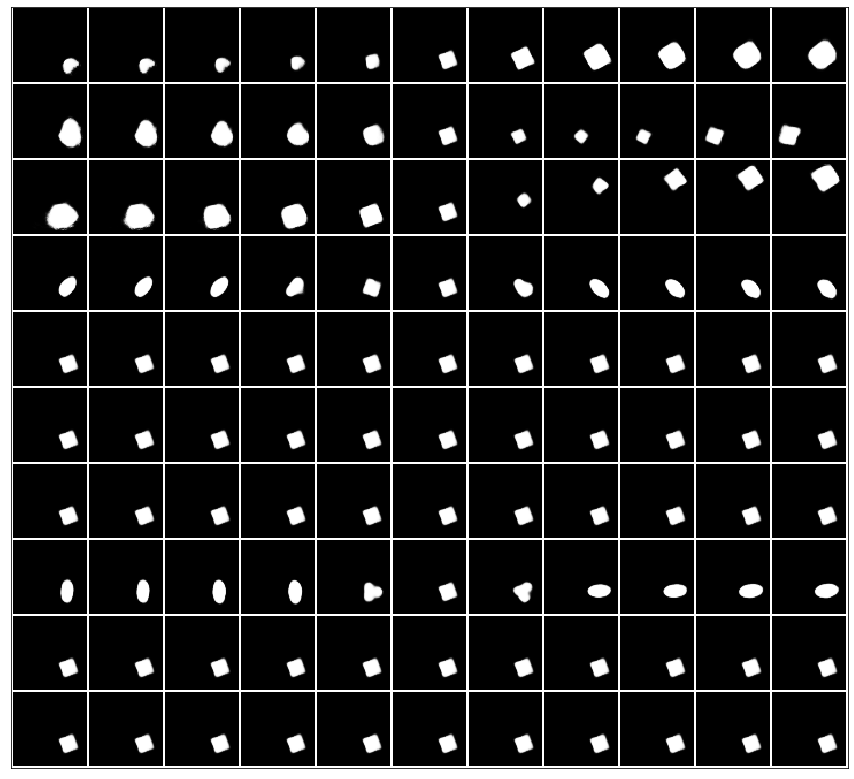

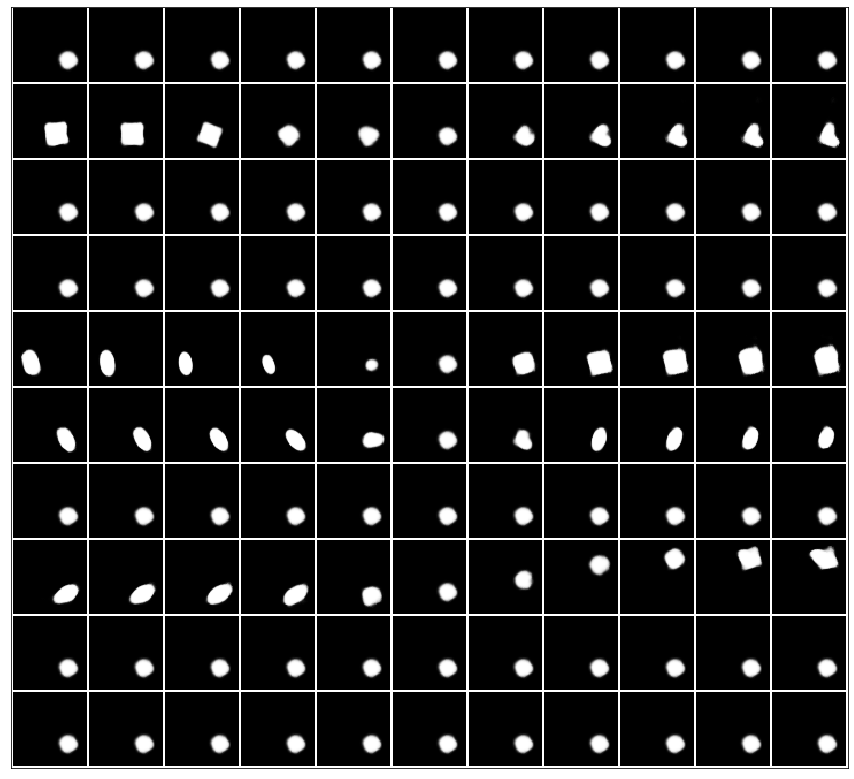

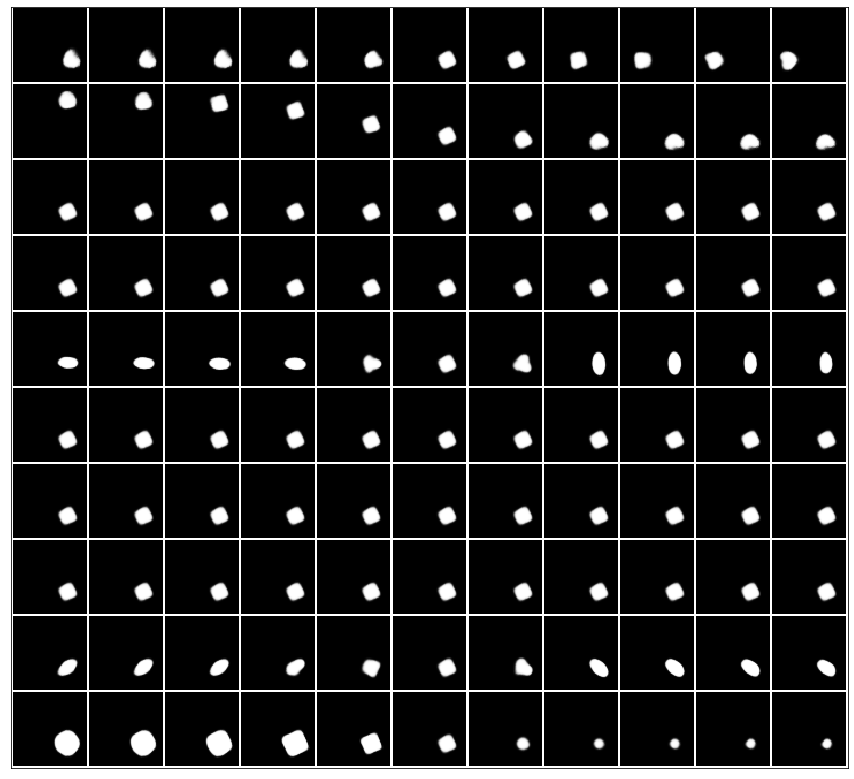

In [0]:
ctr = 0
for model in models:
  if type(model) != int:
    t1="Square Disentanglement Example for VAE"+str(ctr)
    qual_latent_analysis(x_s, model, text=t1)
  ctr +=1

Heart Disentanglement Example for VAE1
Heart Disentanglement Example for VAE3
Heart Disentanglement Example for VAE4
Heart Disentanglement Example for VAE5
Heart Disentanglement Example for VAE7


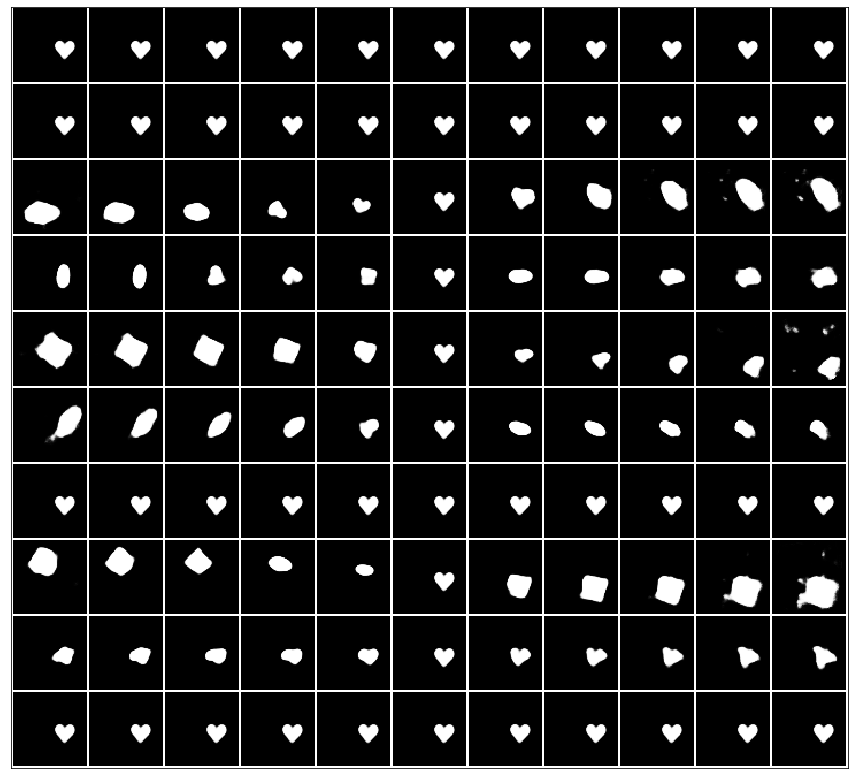

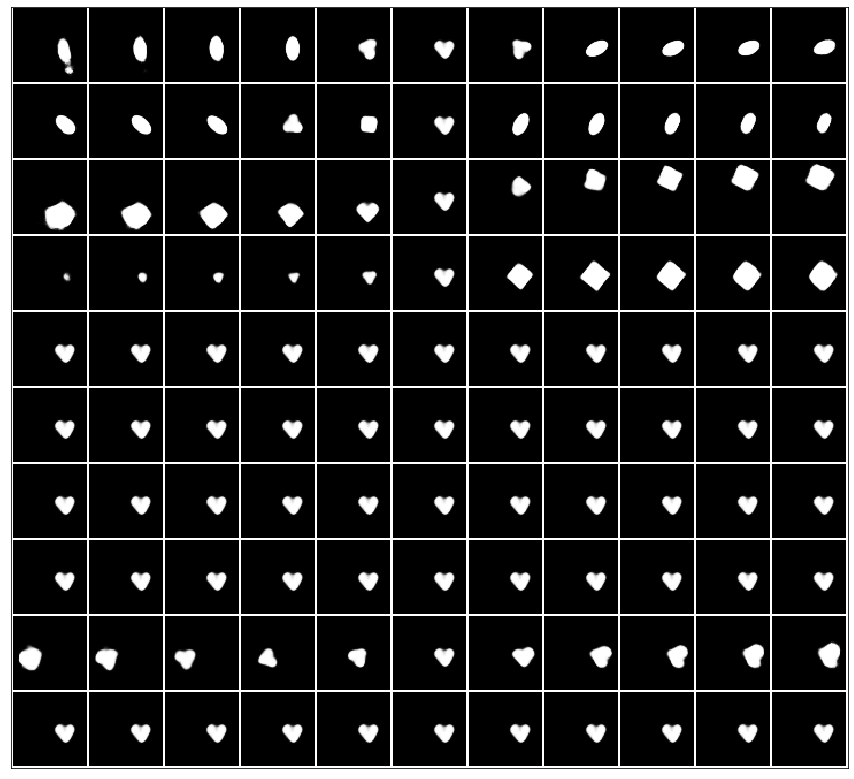

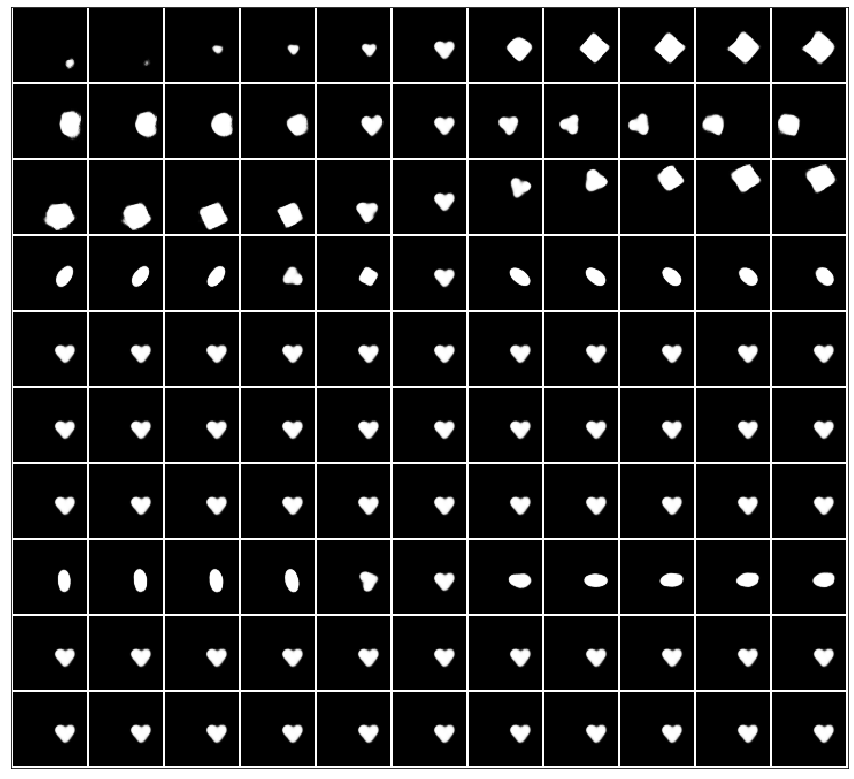

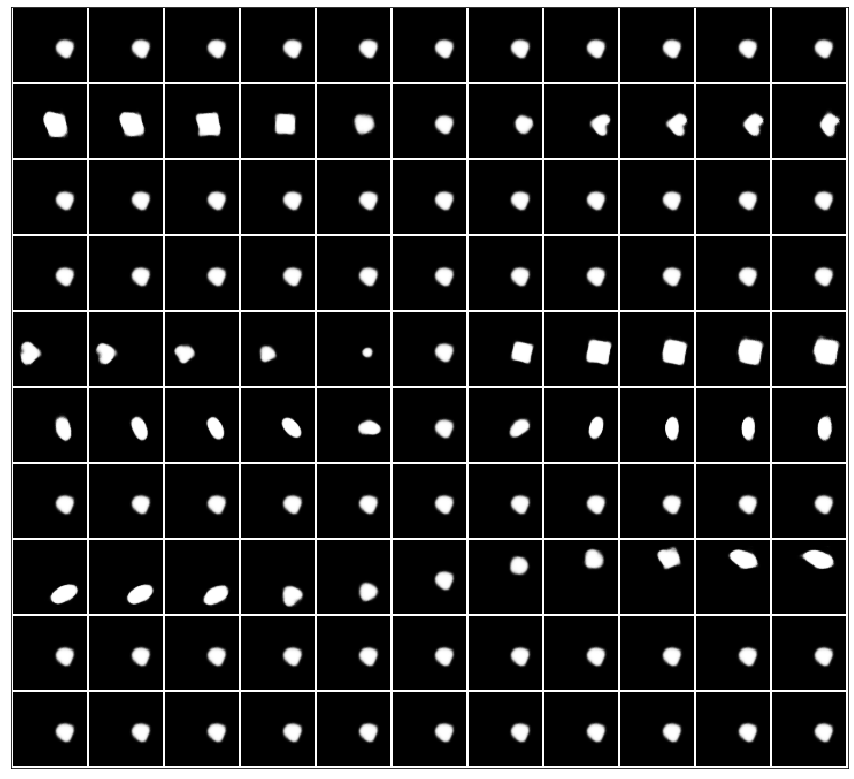

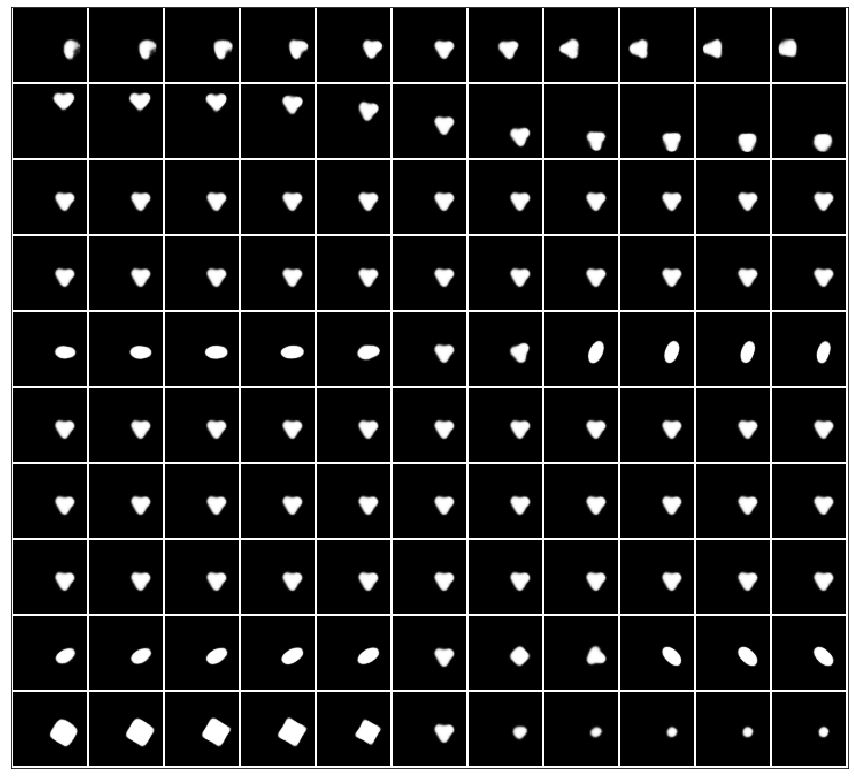

In [0]:
ctr = 0
for model in models:
  if type(model) != int:
    t2="Heart Disentanglement Example for VAE"+str(ctr)
    qual_latent_analysis(x_h, model, text=t2)
  ctr +=1

Oval Disentanglement Example for VAE1
Oval Disentanglement Example for VAE3
Oval Disentanglement Example for VAE4
Oval Disentanglement Example for VAE5
Oval Disentanglement Example for VAE7


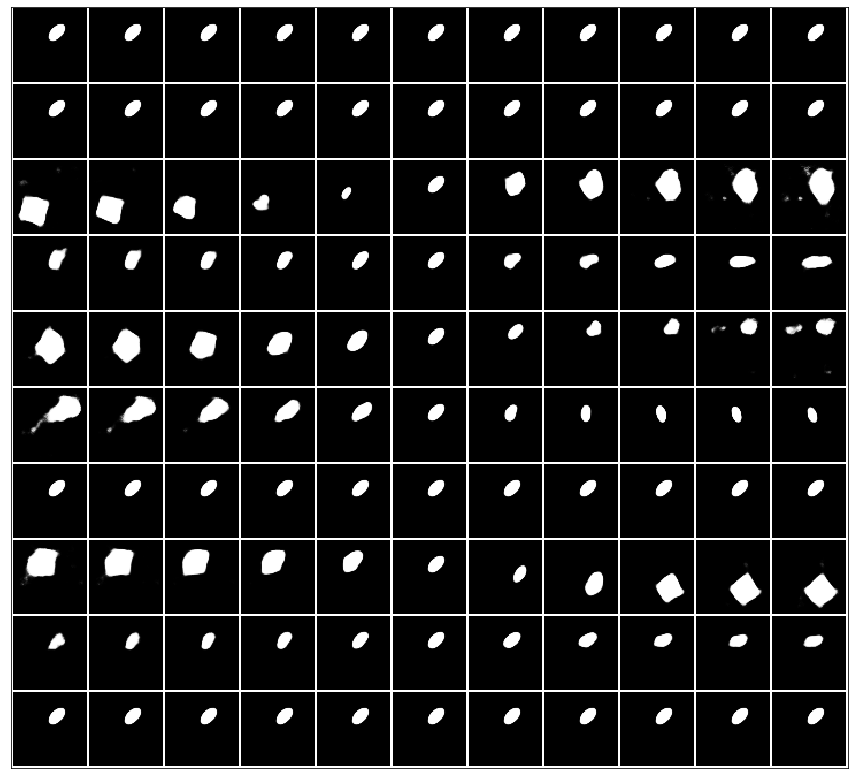

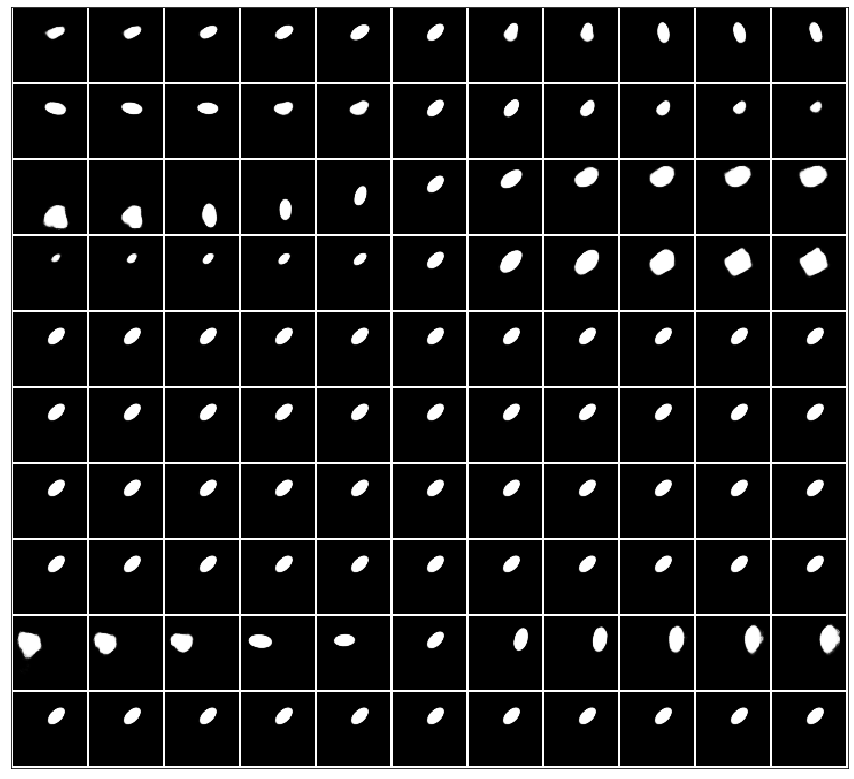

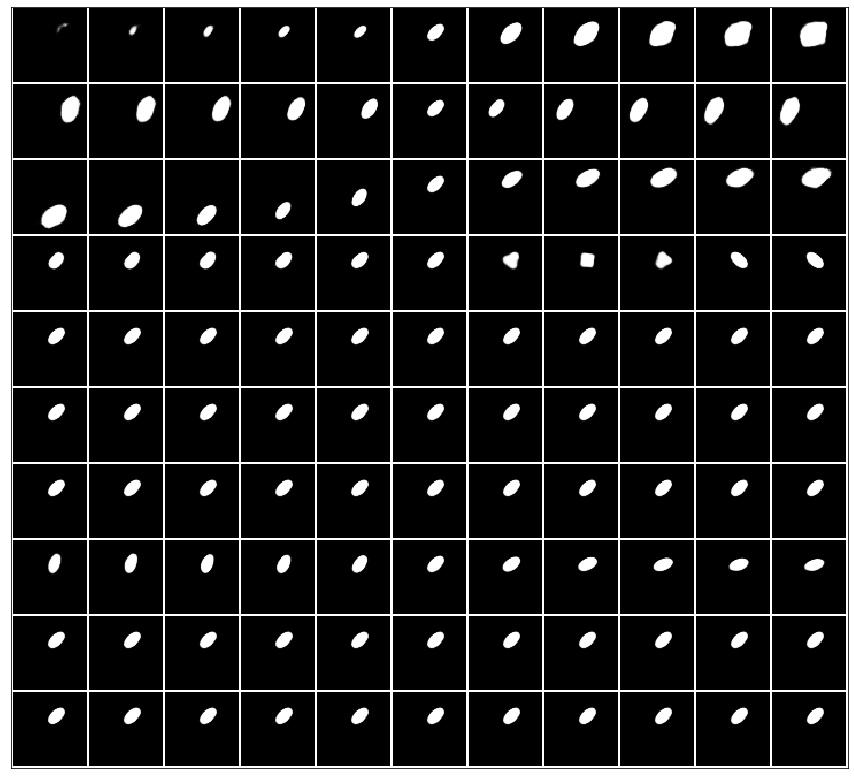

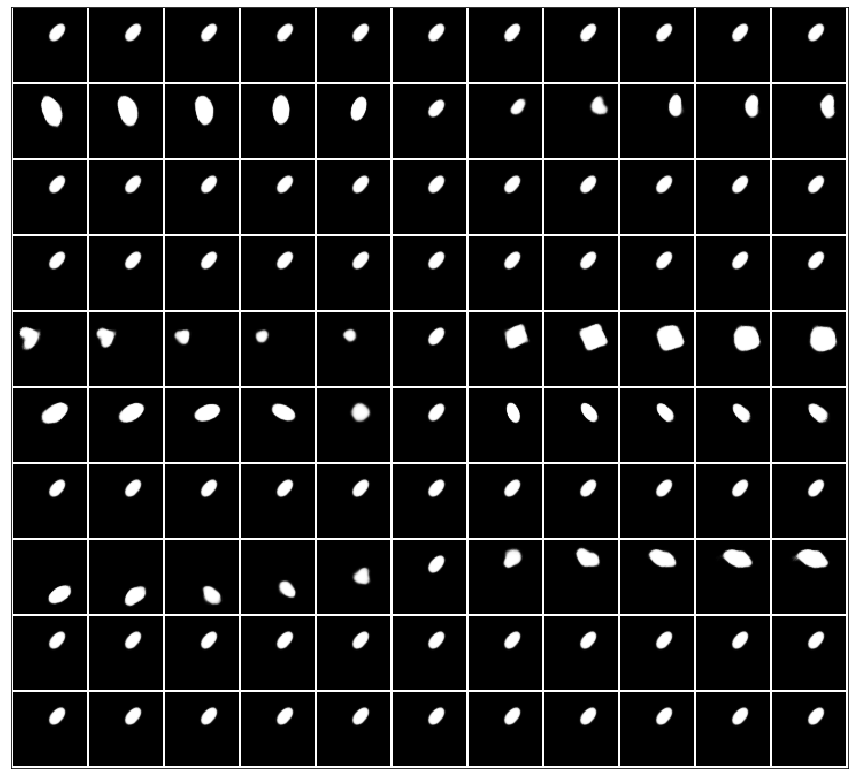

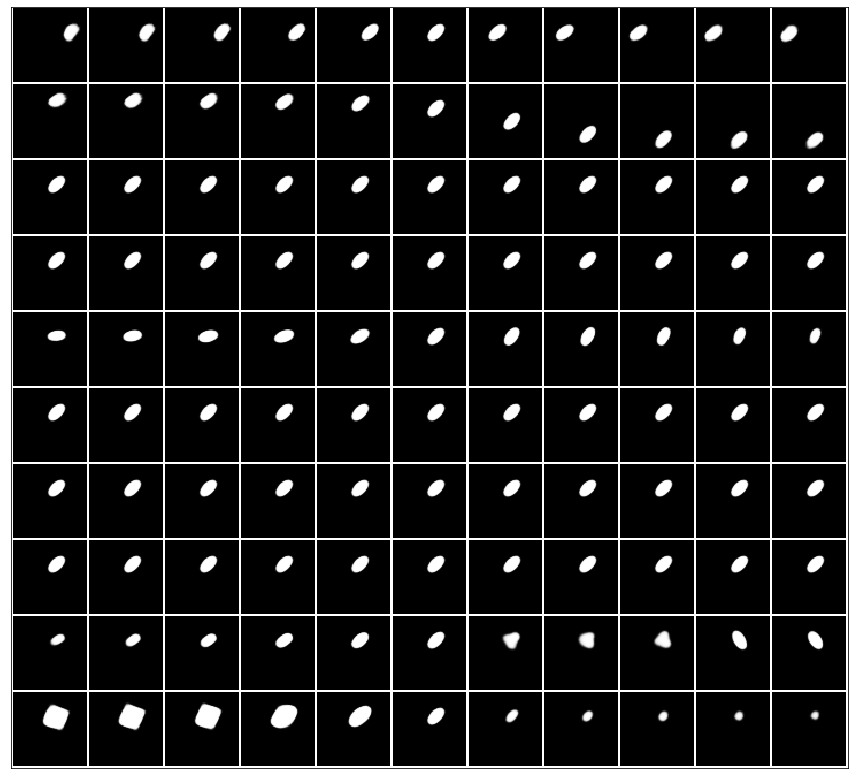

In [0]:
ctr = 0
for model in models:
  if type(model) != int:
    t3="Oval Disentanglement Example for VAE"+str(ctr)
    qual_latent_analysis(x_o, model, text=t3)
  ctr +=1